# Project 1: Web scraping and basic summarization
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*

In this Project you need to implement missing parts of this Jupyter notebook. All the code in the notebook must be reproducible and runnable, so include instructions for the environment setup or other specifics needed to run the notebook.

The idea of this Miniproject is to automatically retrieve structured data from pages [Stat.si](https://www.stat.si/Klasje/Klasje/Tabela/5531) and [eVem](http://evem.gov.si/info/skd-seznam/). 

## Environment setup

In the repository I included a yaml file with all needed dependencies for this notebook to run.
You can create a conda environment with the following command:
`conda env create -f environment.yml`
After creating it, you activate it by `conda activate project-1`.
When you start jupyter notebook you need to select kernel with name `Python [conda env:project-1]`.

Additionally you should download [chromedriver](https://chromedriver.chromium.org/downloads) and save it to
`C:\Program Files (x86)\chromedriver.exe` or somewhere else and change the PATH accordingly in functions below.

In [1]:
# Load all the libraries needed for running the code chunks below
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

import os
import time
import json
import pandas as pd
import regex as re

from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt

## Web scraping

Standard Classification of Activities is a standardized list, which companies need to select to identify the activities of their business. You are expected to extract this hierarchical list along with the content from [eVem](http://evem.gov.si/info/skd-seznam/) and [Stat.si](https://www.stat.si/Klasje/Klasje/Tabela/5531). 

[Stat.si](https://www.stat.si/Klasje/Klasje/Tabela/5531) contains a flat list of activities, where you will find the Slovene and English version of the activity name. For extraction from this resource you can also download Excel and read data from it using a library (e.g. *openpyxl*).

[eVem](http://evem.gov.si/info/skd-seznam/) contains a hierarchical description of activities along with some descriptions - e.g. text, classified_also belongs_here, not_belongs_here, conditions, ...

<table>
    <tr>
        <td style="text-align: left;">eVem Web page example:</td>
        <td style="text-align: left;">Stat.si:</td>
    </tr>
    <tr>
        <td><img src="./eVem.png" /></td>
        <td><img src="./surs.png" /></td>
    </tr>
</table>

First define a hierarchical data schema and then implement parsing. Schema could look like as follows to be able to infer data types (the example should be representative):

```
[
  {
    "code": "I",
    "slv": "GOSTINSTVO",
    "eng": "ACCOMMODATION AND FOOD SERVICE ACTIVITIES",
    "activities": [
      ...,
      {
        "code": "I55",
        "slv": "Gostinske nastanitvene dejavnosti",
        "eng": "Accommodation",
        "activities": [
          ...,
          {
            "code": "I55.100",
            "slv": "Dejavnost hotelov in podobnih nastanitvenih obratov",
            "eng": "Hotels and similar accommodation",
            "text": "V ta podrazred spada nudenje ..."
            "belongs_here": [
              {
                "description": "dajanje nastanitvenih zmogljivosti v najem za krajši čas",
                "examples": ["v hotelih...", "v hotelskih ...", ...]
              },
              ...
            ],
            "not_belongs_here": [
              {
                "description": "dajanje nastanitvenih zmogljivosti v najem za daljši čas, mesečno ali letno",
                "code": "L68"
              },
              ...
            ],
            "classified_also": [
              "Dejavnost hotelov in podobnih ...",
              ...
            ],
            "conditions": "FULL TEXT - new lines preserved"
          },
          ...
        ]
      },
      ...
    ]
  }, 
  {
    ...
]
```

Schema could be defined also using [JSON Schema guidelines](https://json-schema.org/).

My JSON data schema is defined as the example above. The only difference is in *not belongs here* elements.
Instead of *code*, I have a key *codes* that contains a list of strings, since one element can have multiple codes.
In Stat.si data we can see that there are 5 levels, but I decided to leave out levels 3 and 4, since this data is not
included on eVem page, and not relevant for any of the visualizations.

In the implementation below you can also import code from the accompanying *.py* files in the repository.

In [4]:
# Implement Stat.si page parsing

PATH = "C:\Program Files (x86)\chromedriver.exe"

chrome_options = Options()
chrome_options.add_argument("--headless")
pref = {'download.default_directory' : os.getcwd()}
chrome_options.add_experimental_option('prefs', pref)

def parse_stat_si(url):
    driver = webdriver.Chrome(executable_path=PATH, options=chrome_options)
    driver.get(url)
    # saving data to current folder
    save = driver.find_element_by_partial_link_text("Excel")
    save.click()
    
    # reading data from excel to dataframe 
    stat_data = None
    n_tries = 5
    while n_tries > 0:
        try:
            stat_data = pd.read_excel('SKD_2008, V2 - Tabela.xlsx', names=['level', 'category', 'slo', 'eng', 'parent'])
            break
        except:
            time.sleep(5 / n_tries)
            n_tries -= 1
            continue
            
    driver.quit()
    return stat_data


In [5]:
PATH = "C:\Program Files (x86)\chromedriver.exe"

chrome_options = Options()
chrome_options.add_argument("--headless")


def parse_eVem(url):
    eVem_data = {}
    driver = webdriver.Chrome(executable_path=PATH, options=chrome_options)
    driver.get(url)
    driver.find_element_by_class_name("cb-enable").click()            # accept cookies
    skd_list = driver.find_element_by_id("skdseznam")
    skd_items = skd_list.find_elements_by_class_name("itemskd")
    # first we open all the elements
    for item in skd_items:                                          
        button = WebDriverWait(item, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, "triggerskd"))
        )
        driver.execute_script("arguments[0].click();", button)
    # go over opened items again, take out important data
    for item in skd_items:        
        # we are only interested in level 5 items
        if "iskd" in item.get_attribute('class'):                        
            item_id = item.find_element_by_tag_name('b').get_attribute('id')
            item_data = item.find_element_by_class_name("dataskd")
            
            data_children = item_data.find_elements_by_xpath("./*")
            text, belongs_here, not_belongs_here, classified_also, table = "", [], [], [], ""
            position = ""
            content = []
            n = len(data_children)
            i = 0
            names = {"Sem spad", "Sem ne s", "SURS sem", "Pogoji:"}
            while i < n:
                child = data_children[i]
                if child.text in {"", " ", "  "}:                     # some children are empty
                    i += 1
                    continue
                if child.text[:8] not in names:
                    if i == 0:
                        text = child.text
                    else:
                        content.append(child)
                if child.text[:8] in names or i == n-1:
                    if position != "":                                 # if position = "" we just started
                        if position == "Sem spad":
                            belongs_here = parse_belongs(content)
                        elif position == "Sem ne s":
                            not_belongs_here = parse_not_belongs(content)
                        elif position == "SURS sem":
                            classified_also = parse_classified(content)
                        elif position != "Pogoji:": print("Wrong position: " + position)
                    position = child.text[:8]
                    if child.text != "Sem spada tudi:":
                        content = []
                if child.text == "Pogoji:":                             # if table exists, it is the last child
                    table = data_children[i+1].find_element_by_tag_name('table').text
                    break
                i += 1
            eVem_data[item_id] = {"text": text, "belongs_here": belongs_here, "not_belongs_here": not_belongs_here, 
                                  "classified_also": classified_also, "conditions": table}
    driver.quit()
    return eVem_data


def parse_belongs(content):
    belongs = []
    for c in content:
        if c.tag_name == 'p':                                       # for id >= 82.110
            text = c.text
            if text[:3] == "·  ":                                   # for all elements that begin with ".   "
                text = text[3:]
            belongs.append({"description": text, "examples": []})
        elif c.tag_name == 'ul':                                    # for id < 82.110
            children = c.find_elements_by_xpath("./*")
            i = 0
            description = None
            for child in children:
                if child.tag_name == 'li':
                    description = child.text
                    if i + 1 == len(children) or children[i+1].tag_name != 'ul':
                        belongs.append({"description": description,"examples": []})
                elif child.tag_name == 'ul':
                    examples = [example.text for example in child.find_elements_by_tag_name('li')]
                    belongs.append({"description": description, "examples": examples})
                i += 1
    return belongs


def parse_not_belongs(content):
    not_belongs = []
    for c in content:
        if c.tag_name == 'p':
            text = c.text
            if text[:3] == "·  ":
                text = text[3:]
            description, codes = split_codes(text)
            not_belongs.append({"description": description, "codes": codes})
        elif c.tag_name == 'ul':
            elements = c.find_elements_by_tag_name('li')
            for element in elements:
                text = element.text
                split = split_codes(text)
                description, codes = split[0], split[1]
                not_belongs.append({"description": description, "codes": codes})
    return not_belongs

def split_codes(text):
    description = text
    codes = []
    if ", gl. " in text:
        split = text.split(', gl. ')
        if len(split) > 2:              # only one occasion (26.700)
            description = split[0] + ", glej " + split[1] + ')'
            codes = [split[2][:-1]]
        else:
            description, code = split[0], split[1]
            codes = re.findall('\d+[.]*\d*', code)
    elif "(gl." in text:
        split1 = text.split(' (gl. ')
        split2 = split1[1].split(')')
        description = split1[0] + split2[1]
        codes = [split2[0]]
    elif " gl. " in text:
        split = text.split(' gl. ')
        description = split[0]
        codes = [split[1]]
    return description, codes

def parse_classified(content):
    classified = []
    for c in content:
        if c.tag_name == 'ul':
            for element in c.find_elements_by_tag_name('li'):
                classified.append(element.text)
        elif c.tag_name == 'p':
            text = c.text
            if text[:3] == "·  ":
                text = text[3:]
            classified.append(text)
    return classified


In [6]:
# Implement parsing, data merging and final representation

def parse_all(stat_url, eVem_url):
    stat_data = parse_stat_si(stat_url)
    eVem_data = parse_eVem(eVem_url)
    data = []
    level1_data = stat_data[stat_data['level'] == 1]
    for row in level1_data.itertuples(index=False):
        level2_data = stat_data.loc[(stat_data['level'] == 2) & (row.category == stat_data['category'].str[0])]
        activities = []
        for row2 in level2_data.itertuples(index=False):
            level5_data = stat_data.loc[(stat_data['level'] == 5) & (row2.category == stat_data['category'].str[:3])]
            act2 = []
            for row5 in level5_data.itertuples(index=False):
                if row5.category[1:] in eVem_data:
                    eVem_dict = eVem_data[row5.category[1:]]
                else:
                    eVem_dict = {"text": "", "belongs_here": [], "not_belongs_here": [],
                                 "classified_also": [], "conditions": ""}
                act2.append(dict({"code": row5.category, "slv": row5.slo, "eng": row5.eng}, **eVem_dict))
            activities.append({"code": row2.category, "slv": row2.slo, "eng": row2.eng, "activities": act2})
        data.append({"code": row.category, "slv": row.slo, "eng": row.eng, "activities": activities})
    return data


In [7]:
# Main program and data export into a JSON

EVEM_URL = "http://evem.gov.si/info/skd-seznam/"
STAT_SI_URL = "https://www.stat.si/Klasje/Klasje/Tabela/5531"

data = parse_all(STAT_SI_URL, EVEM_URL)
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False)


## Basic summarization

Prepare and show at least five basic visualizations of the extracted data as presented in the chapter *Summarizing data - the basics* of the course's e-book. Explain each visualization of the data.

In [2]:
# Read data from JSON

with open("data.json", encoding='utf-8') as f:
    data = json.load(f)


### Visualization 1 - number of activities per category

Visualization 1 shows how many activities are in each level 2 category.
We can see that the largest one is sub-category G46, containing 48 activities.
These categories are grouped by level one categories.
The largest group is group C, that has 24 sub-categories with 232 activities all together.
On the plot we can also see how many sub-categories are in each category.

I prepared the data by collecting it in a dataframe that contains level 1 and level 2 categories and number of
activities in each level 2 category. Then I extracted this data to CSV, read it with R and draw the plot there.
The code for the plot is in file "plots.R".

In [9]:
# Visualization 1 code

df = pd.DataFrame(columns=["category", "sub_category", "nr_activities"])

for category in data:
    cat_name = category['code']
    for activity in category['activities']:
        sub_cat_name = activity['code']
        nr_activities = len(activity['activities'])
        df = df.append({"category": cat_name, "sub_category": sub_cat_name, "nr_activities": nr_activities},
                       ignore_index=True)

df.to_csv('nr_categories.csv')


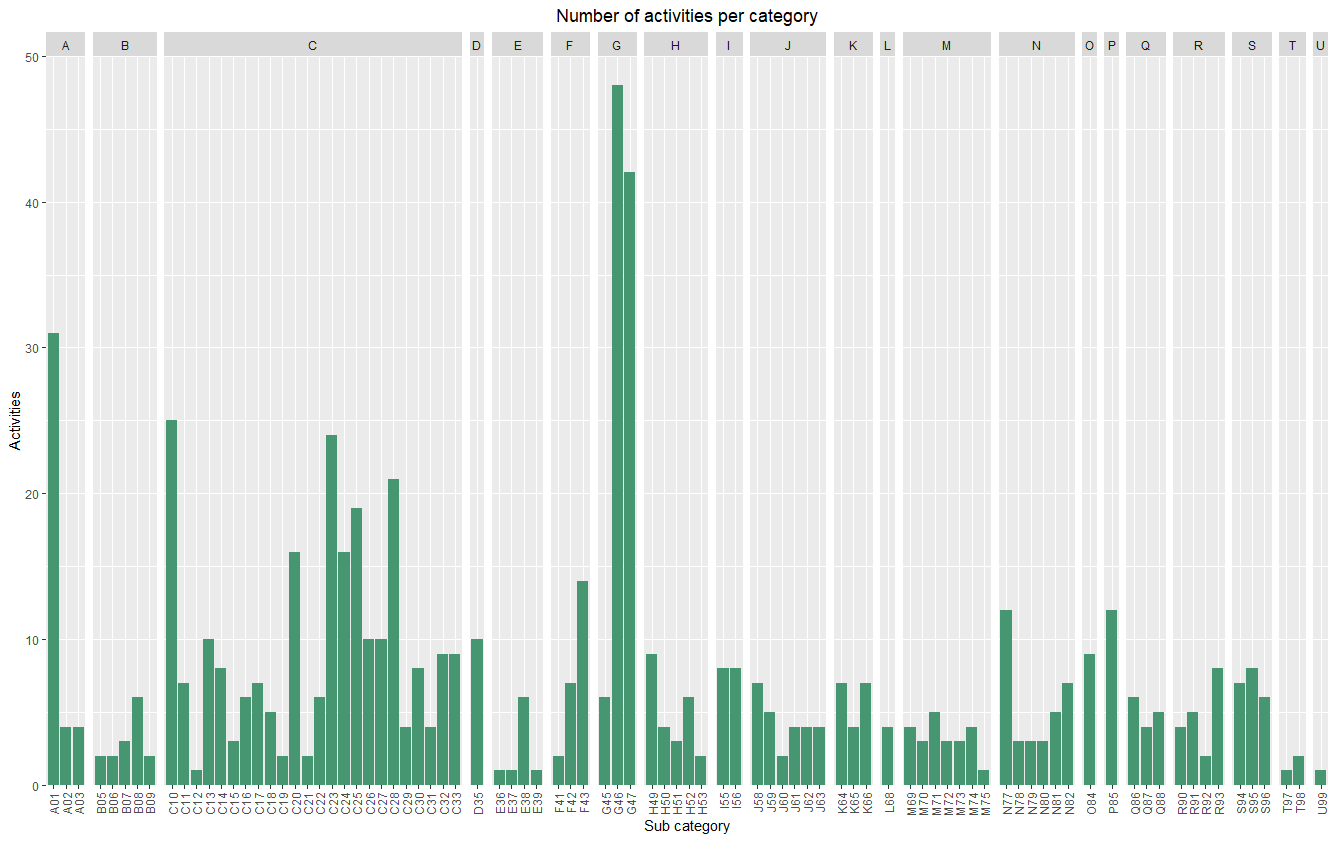

In [11]:
# some values used in the description
nr_act_c = sum(df[df['category'] == 'C']['nr_activities'])
nr_act_g = sum(df[df['category'] == 'G']['nr_activities'])
nr_sub_cat_c = len(df[df['category'] == 'C'])

# plot
Image("plot_nr_categories.png")


### Visualization 2 - connection graph based on *not belonging connections*

First I tried building a connection graph directly from level 5 connections, and then from level 2 connections,
but they were both too big with too many edges for anything to be visible.
So I built a graph that has level 1 categories as nodes and weighted edges,
based on number of *not belonging connections* between those categories.
Edges with weights bigger than 10 are colored red and those with weights smaller than 5 are green and dashed,
so we can easily see between which categories are the most connections.


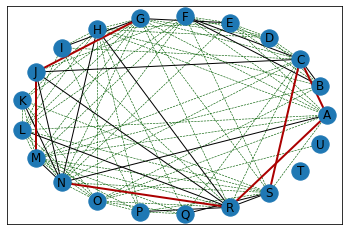

In [12]:
# Visualization 2 code

G = nx.Graph()
nodes = []
edges = {}
nr_to_letter = {cat[1:]: cat[0] for cat in df['sub_category'].values}

# finding all nodes and edges
for el in data:
    for element in el["activities"]:
        for activity in element["activities"]:
            act_code = activity["code"][0]
            if act_code not in nodes:
                nodes.append(act_code)
            for not_bel in activity["not_belongs_here"]:
                if len(not_bel["codes"]) > 0:
                    for code in not_bel["codes"]:
                        code_letter = nr_to_letter[code[:2]]
                        if code_letter != act_code:
                            if (act_code, code_letter) not in edges:
                                edges[(act_code, code_letter)] = 1
                            else:
                                edges[(act_code, code_letter)] += 1

# building the graph
G.add_nodes_from(nodes)
for n1, n2 in edges:
    G.add_edge(n1, n2, weight=edges[(n1, n2)])

large_weights = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 10]
midle_weights = [(u, v) for (u, v, d) in G.edges(data=True) if 5 <= d["weight"] <= 10]
small_weights = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 5]

# drawing the nodes
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)

# drawing different colored edges for smallest and largest weights
nx.draw_networkx_edges(G, pos, edgelist=small_weights, width=0.6, edge_color="#025e00", style="dashed")
nx.draw_networkx_edges(G, pos, edgelist=midle_weights)
nx.draw_networkx_edges(G, pos, edgelist=large_weights, width=2, edge_color="#ab0000")

plt.show()

### Visualization 3 - number of *not belongs here* and *belongs here* elements

To better understand the previous visualization,
we should also consider how many *not belongs here* elements are in each category.
We can see that category C exceeds the others by far. This explains why C has so many connections seen in visualization 2, but more importantly, we can observe that categories R and J are more interesting, since they dont have so many activities (seen in visualization 1) and *not belongs here* elements (seen here), but still have a lot of connections.
On the same plot I added the number of *belongs here* elements in categories, so we can also compare those numbers.

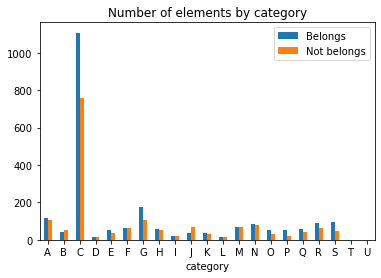

In [17]:
# Visualization 3 code

df_not_belongs = pd.DataFrame(columns=["category", "Belongs", "Not belongs"])

for category in data:
    cat_name = category['code']
    nr_not_belongs = nr_belongs = 0
    for category2 in category['activities']:
        for activity in category2['activities']:
            nr_not_belongs += len(activity['not_belongs_here'])
            nr_belongs += len(activity['belongs_here'])
    df_not_belongs = df_not_belongs.append({"category": cat_name, "Belongs": nr_belongs, "Not belongs": nr_not_belongs},
                                           ignore_index=True)

df_not_belongs.plot.bar(x="category", title="Number of elements by category", rot=0)
plt.show()


### Visualization 4 - average number of missing elements per activity

In this visualization we can see what is the average number of missing elements (*text, belongs here, not belongs here,
classified also* and *conditions*) per activity for different sub-categories.
I wanted to see if this number is correlated to the number of sub-categories in a category,
but I can't see that connection.
We can also see which categories should be better explained. One of them is category T, and also category G.
This also shows that missing elements are not correlated to number of activities in category, since G is one of the biggest
and T is one of the smallest ones.

In [19]:
# Visualization 4 code

df_missing = pd.DataFrame(columns=["category", "sub_category", "nr_missing"])

for category in data:
    cat_name = category['code']
    for category2 in category['activities']:
        sub_cat_name = category2['code']
        nr_missing = 0
        nr_activities = len(category2['activities'])
        for activity in category2['activities']:
            for key in activity:
                nr_missing += 1 if len(activity[key]) == 0 else 0
        df_missing = df_missing.append({"category": cat_name, "sub_category": sub_cat_name,
                                    "nr_missing": nr_missing/nr_activities}, ignore_index=True)

df_missing.to_csv('nr_missing.csv')


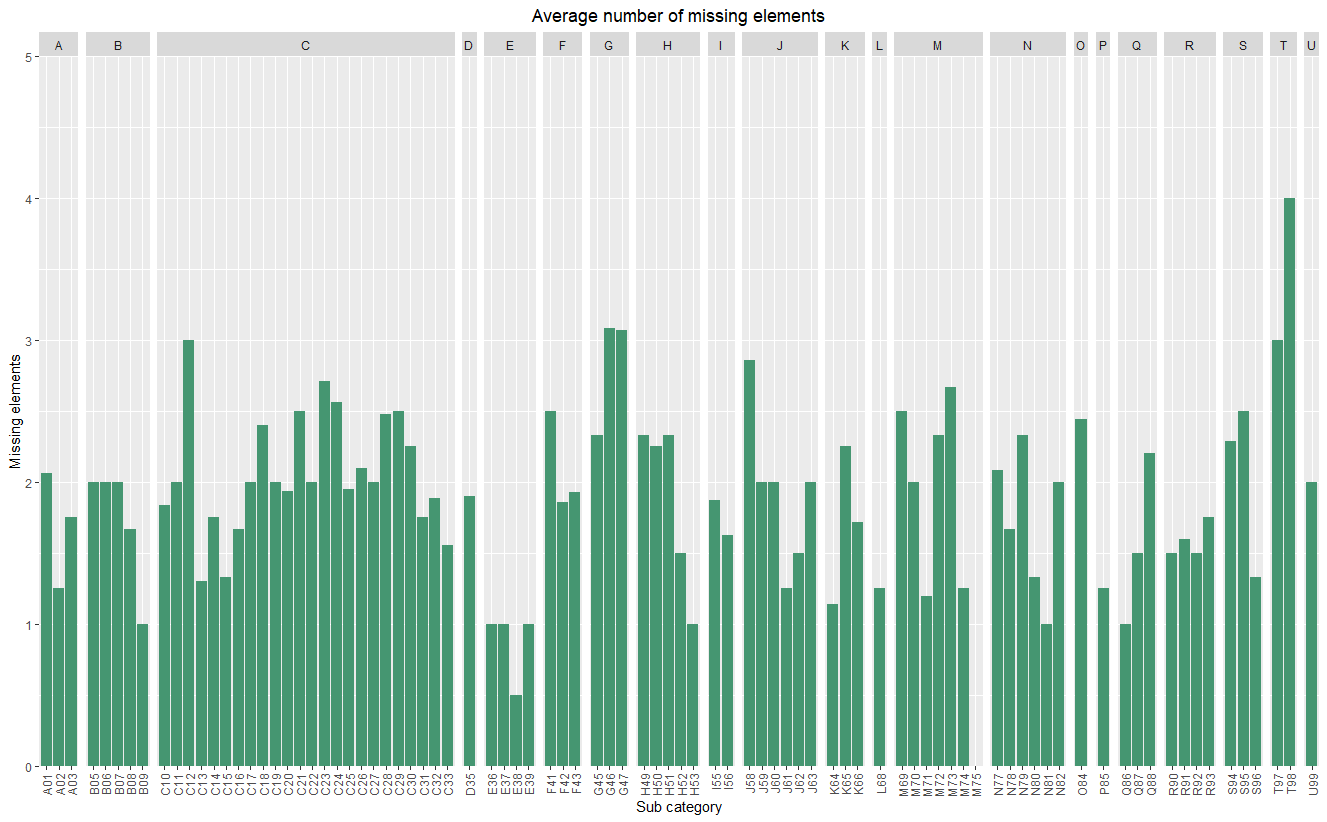

In [20]:
Image('plot_nr_missing.png')

### Visualization 5 - correlation between length of text and number of belongs here elements

For the last visualization I searched if there is any correlation between the number of words in the *text* and the
number of *belongs here* elements. From the plot below we can see that the majority of points is located near the
starting point and on the axes. That could mean that each activity is either explained through *text* or with a list of
what *belongs here*.
I counted that 9% of all activities has no *belong here* elements and 89% has no *text*.
I also calculated means, medians and variance of both data and showed first two summaries for both on the plot.

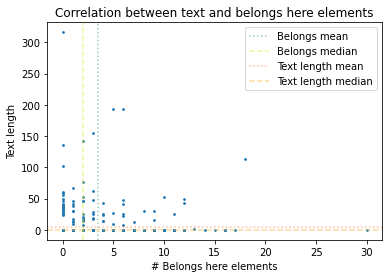

In [16]:
# Visualization 5 code

df_text_length = pd.DataFrame(columns=["activity_code", "Text length", "# Belongs here elements"])

for category in data:
    for category2 in category['activities']:
        for activity in category2['activities']:
            activity_code = activity["code"]
            nr_belongs = len(activity["belongs_here"])
            text_length = len(activity["text"].split(" ")) if len(activity["text"]) != 0 else 0
            df_text_length = df_text_length.append({"activity_code": activity_code, "Text length": text_length,
                                                    "# Belongs here elements": nr_belongs}, ignore_index=True)

no_text = df_text_length[df_text_length['Text length'] == 0].shape[0] / df_text_length.shape[0]
no_belongs = df_text_length[df_text_length['# Belongs here elements'] == 0].shape[0] / df_text_length.shape[0]

text_median = df_text_length['Text length'].median()
belongs_median = df_text_length['# Belongs here elements'].median()  # not needed since we know 89% of data = 0

belongs_mean = df_text_length['# Belongs here elements'].mean()
text_mean = df_text_length['Text length'].mean()

belongs_var = df_text_length['# Belongs here elements'].var()
text_var = df_text_length['Text length'].var()

df_text_length.plot.scatter("# Belongs here elements", "Text length", s=3,
                            title="Correlation between text and belongs here elements")

plt.axvline(x=belongs_mean, color="#459671", linestyle=":", label="Belongs mean", alpha=0.5)
plt.axvline(x=belongs_median, color="#e1f03e", linestyle="dashed", label="Belongs median", alpha=0.5)
plt.axhline(y=text_mean, color="#fc7b3a", linestyle=":", label="Text length mean", alpha=0.5)
plt.axhline(y=text_median, color="#f5bc38", linestyle="dashed", label="Text length median", alpha=0.5)
plt.legend()
plt.show()